In [1]:
import sys
sys.path.append(r'..\\')
from ioMicro import *

import scanpy as sc
from scipy.stats import zscore
import pandas as pd

In [2]:
fit_folder = r'\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\Drift'

In [25]:
_fls = np.sort(glob.glob(fit_folder+os.sep+'*'))
_fls[:20]

array(['\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\Drift\\Conv_zscan__00--H0__set1--col0__Xhfits.npz',
       '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\Drift\\Conv_zscan__00--H0__set1--col1__Xhfits.npz',
       '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\Drift\\Conv_zscan__00--H0__set1--col2__Xhfits.npz',
       '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\Drift\\Conv_zscan__00--H0__set2--col0__Xhfits.npz',
       '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\Drift\\Conv_zscan__00--H0__set2--col1__Xhfits.npz',
       '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\Drift\\Conv_zscan__00--H0__set2--col2__Xhfits.npz',
       '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\Drift\\Conv_zscan__00--H0__set3--col0__Xhfits.npz',
       '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\Drift\\Conv_zscan__00--H0__set3--col1__Xhfits.npz',
       '\\\\192.168.0.21\\bbfishdc21\\HttHuman_S

In [137]:
fov = 'Conv_zscan__30'
set_ = '_set5'
drift_fl = fit_folder+os.sep+'driftNew_'+fov+'--'+set_+'.pkl'
fit_fl0 = fit_folder+os.sep+fov+'--P3__Htt_CAG_B_polyA_'+set_+'--col0__Xhfits.npz'
fit_fl1 = fit_folder+os.sep+fov+'--P3__Htt_CAG_B_polyA_'+set_+'--col1__Xhfits.npz'
Xh0 = np.load(fit_fl0,allow_pickle=True)['Xh']
Xh1 = np.load(fit_fl1,allow_pickle=True)['Xh']
Xh0f = Xh0[(Xh0[:,-1]>15000)&(Xh0[:,-2]>0.5),:]

tree = cKDTree(Xh1[:,:3])
d,inds = tree.query(Xh0f[:,:3])
isd = d<2.5
Xh1_ = Xh1[inds[isd]]
Xh0f_ = Xh0f[isd]

hCAG =  Xh1[inds,-1]
hHTT = Xh0f[:,-1]
hCAG[~isd]=np.min(hCAG)

(array([2136.,  536.,  489.,  385.,  272.,  146.,   66.,   24.,   10.,
           3.]),
 array([ 8.18896484,  8.49905586,  8.80914593,  9.11923599,  9.42932701,
         9.73941803, 10.04950809, 10.35959816, 10.66968918, 10.9797802 ,
        11.28987026]),
 <BarContainer object of 10 artists>)

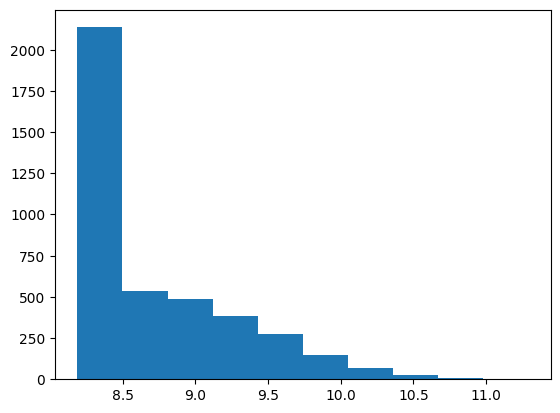

In [140]:
plt.hist(np.log(hCAG),bins=10)

In [253]:
import napari
def get_med_color(save_folder=r'\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\MERFISH_Analysis_group1',icol=0):
    fl_med = save_folder+os.sep+'med_col_raw'+str(icol)+'.npz'
    im_med = np.array(np.load(fl_med)['im'],dtype=np.float32)
    im_med = cv2.blur(im_med,(20,20))
    return im_med
def sample_im(imCAG__,X,s=2):
    X_ = np.round(X).astype(int)[:,np.newaxis]
    Xi = (np.indices([2*s+1]*3)-s).reshape([3,-1]).T
    Xi = Xi[np.sum(Xi*Xi,-1)<=s*s]
    Xi = Xi[np.newaxis]
    X_ = X_+Xi
    sh = np.array(imCAG__.shape)-1
    X_=np.abs(X_)
    iz = 0
    for iz in range(X_.shape[-1]):
        X_[...,iz][X_[...,iz]>sh[iz]]=sh[iz]-(X_[...,iz][X_[...,iz]>sh[iz]]-sh[iz])
    return imCAG__[(X_[...,0],X_[...,1],X_[...,2])]
fl = r'\\192.168.0.96\bbfish124\HttHuman_Snonia__06_12_2023\P3__Htt_CAG_B_polyA_'+set_+os.sep+fov+'.zarr'
im = read_im(fl)
imCAG = np.array(im[1],dtype=np.float32)
im_med = get_med_color(icol=1)
imCAG = imCAG/im_med*np.median(im_med)

#imCAG_ = full_deconv(imCAG,s_=500,pad=100,psf=np.load(r'C:\Scripts\NMERFISH\psfs\psf_750_Scope3_final.npy'),
#            parameters={'method': 'wiener', 'beta': 0.001, 'niter': 50},gpu=True,force=False)
imCAG__ = full_deconv(imCAG,s_=500,pad=100,psf=np.load(r'C:\Scripts\NMERFISH\psfs\psf_750_Scope3_final.npy'),
            parameters={'method': 'lucy', 'beta': 0.001, 'niter': 50},gpu=True,force=False)

imHTT = np.array(im[0],dtype=np.float32)
im_med = get_med_color(icol=0)
imHTT = imHTT/im_med*np.median(im_med)
imHTT__ = full_deconv(imHTT,s_=500,pad=100,psf=np.load(r'C:\Scripts\NMERFISH\psfs\psf_750_Scope3_final.npy'),
            parameters={'method': 'lucy', 'beta': 0.001, 'niter': 50},gpu=True,force=False)
imHTT__n = norm_slice(imHTT__,s=30)
XhHTT = get_local_maxfast_tensor(imHTT__n,th_fit=12000,im_raw=imHTT__,dic_psf=None,delta=1,delta_fit=3,sigmaZ=1,sigmaXY=1.5,gpu=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [01:52<00:00,  3.12s/it]


In [283]:
X = XhHTT[:,:3]
h_CAG_ = np.max(sample_im(imCAG__,X,s=2),axis=-1)-np.min(sample_im(imCAG__,X,s=4),axis=-1)
h_HTT_= np.max(sample_im(imHTT__,X,s=2),axis=-1)-np.min(sample_im(imHTT__,X,s=4),axis=-1)

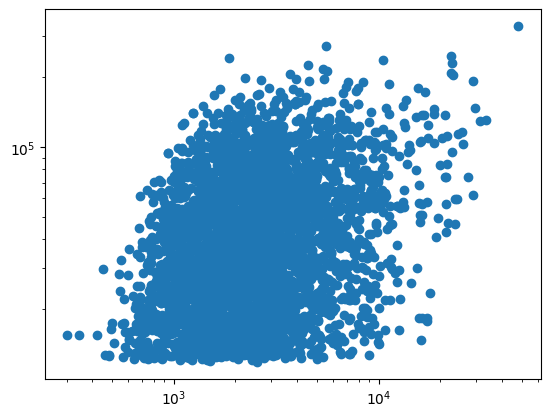

In [292]:
plt.loglog(h_CAG_,h_HTT_,'o')

In [289]:
#set_

(array([  1.,   0.,   1.,   0.,   0.,   0.,   1.,   1.,   1.,   4.,   1.,
          3.,   6.,   6.,   4.,  16.,  24.,  21.,  32.,  26.,  28.,  52.,
         49.,  45.,  46.,  61.,  84.,  66.,  64.,  97.,  83.,  69., 102.,
         87.,  89., 100., 118., 116., 111., 127.,  98., 104., 108.,  98.,
        124.,  92., 104.,  71.,  91.,  84.,  61.,  98.,  70.,  53.,  57.,
         63.,  51.,  45.,  45.,  35.,  31.,  30.,  38.,  27.,  22.,  26.,
         23.,  21.,  21.,  14.,  13.,  13.,   3.,   8.,   6.,   4.,   2.,
          7.,  10.,   5.,   2.,   4.,   3.,   5.,   3.,   6.,   3.,   2.,
          1.,   1.,   2.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([ 5.71318054,  5.76387882,  5.81457758,  5.86527586,  5.91597414,
         5.9666729 ,  6.01737118,  6.06806946,  6.11876774,  6.1694665 ,
         6.22016478,  6.27086306,  6.32156181,  6.37226009,  6.42295837,
         6.47365665,  6.52435541,  6.57505369,  6.62575197,  6.67645073,
         6.72714901,  6.77

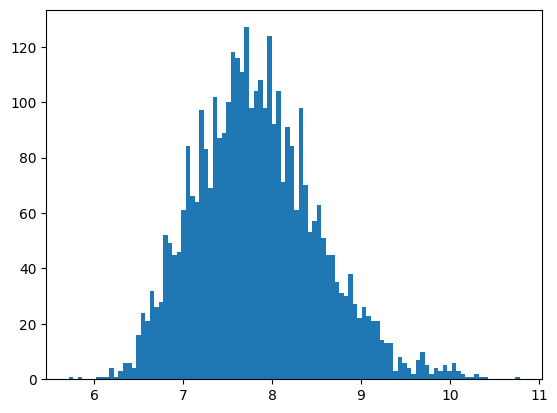

In [287]:
plt.hist(np.log(h_CAG_),bins=100)

In [278]:
#plt.hist(np.log(XhHTT[:,-1]),bins=20);

In [279]:
#np.exp(9.5)

In [275]:
vv = napari.view_image(imCAG__)
vv.add_image(imHTT__)
X = XhHTT[:,:3]
s = np.clip(XhHTT[:,-1]/15000,0,1)*4
vv.add_points(X,face_color=[0,0,0,0],edge_color='g',size=s)

<Points layer 'X' at 0x25a645c5fa0>

In [250]:
vv = napari.view_image(imCAG__)
vv.add_image(imHTT__)

<Image layer 'imHTT__' at 0x2587196b970>

In [ ]:
np.load()

In [124]:
vv = napari.view_image(imCAG__)
vv.add_image(imHTT__)

X = Xh1_[:,:3]
s = Xh1_[:,-1]/15000*10
vv.add_points(X,face_color=[0,0,0,0],edge_color='g',size=s)
X = Xh0f[:,:3]
s = Xh0f[:,-1]/50000*10
vv.add_points(X,face_color=[0,0,0,0],edge_color='r',size=s)

<Points layer 'X [1]' at 0x25534144f10>

In [219]:

def sample_im(imCAG__,X,s=2):
    X_ = np.round(X).astype(int)[:,np.newaxis]
    Xi = (np.indices([2*s+1]*3)-s).reshape([3,-1]).T
    Xi = Xi[np.sum(Xi*Xi,-1)<=s*s]
    Xi = Xi[np.newaxis]
    X_ = X_+Xi
    sh = np.array(imCAG__.shape)-1
    X_=np.abs(X_)
    iz = 0
    for iz in range(X_.shape[-1]):
        X_[...,iz][X_[...,iz]>sh[iz]]=sh[iz]-(X_[...,iz][X_[...,iz]>sh[iz]]-sh[iz])
    return imCAG__[(X_[...,0],X_[...,1],X_[...,2])]


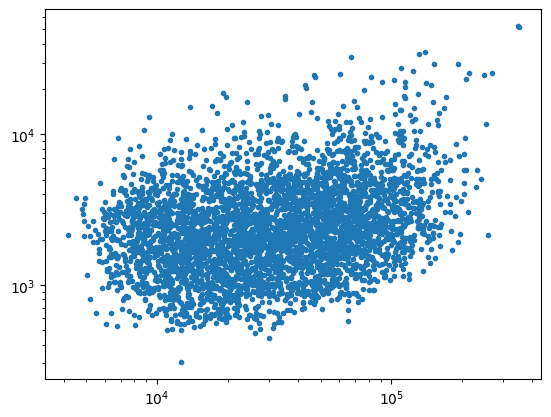

In [231]:
plt.loglog(h_HTT_,h_CAG_,'.')

In [241]:
np.exp(10)

22026.465794806718

(array([ 1.,  1.,  0.,  6.,  3.,  3.,  6.,  9., 16., 23., 23., 21., 24.,
        32., 34., 49., 43., 50., 40., 32., 41., 76., 62., 56., 53., 74.,
        68., 72., 61., 71., 59., 51., 67., 67., 74., 66., 64., 72., 79.,
        71., 58., 69., 77., 59., 62., 72., 63., 69., 63., 71., 82., 70.,
        65., 57., 61., 91., 63., 88., 77., 57., 73., 75., 73., 63., 62.,
        55., 57., 50., 32., 41., 41., 29., 45., 43., 43., 27., 21., 28.,
        19., 16., 15., 12., 15.,  5.,  5.,  3.,  5.,  6.,  5.,  0.,  2.,
         1.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,  2.]),
 array([ 8.33191299,  8.37621498,  8.42051601,  8.464818  ,  8.50911999,
         8.55342102,  8.59772301,  8.64202499,  8.68632698,  8.73062801,
         8.77493   ,  8.81923199,  8.86353302,  8.90783501,  8.95213699,
         8.99643803,  9.04074001,  9.085042  ,  9.12934303,  9.17364502,
         9.21794701,  9.26224804,  9.30655003,  9.35085201,  9.395154  ,
         9.43945503,  9.48375702,  9.52805901,  9.57236004,  9.616662

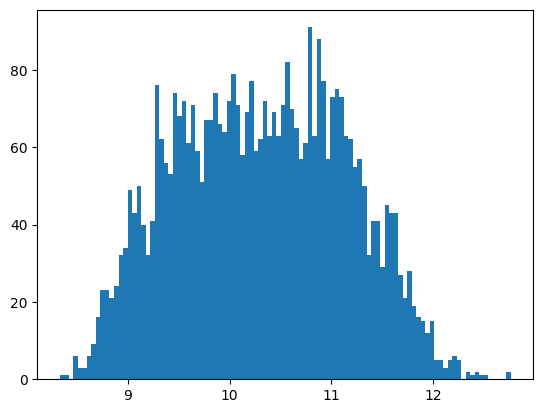

In [239]:
plt.hist(np.log(h_HTT_),bins=100)

In [220]:
X = Xh0f[:,:3]
h_CAG_ = np.max(sample_im(imCAG__,X,s=2),axis=-1)-np.min(sample_im(imCAG__,X,s=4),axis=-1)
h_HTT_= np.max(sample_im(imHTT__,X,s=2),axis=-1)-np.min(sample_im(imHTT__,X,s=4),axis=-1)

In [217]:
h_CAG_ = np.max(imCAG__[(X_[...,0],X_[...,1],X_[...,2])],axis=-1)
h_HTT_ = np.max(imHTT__[(X_[...,0],X_[...,1],X_[...,2])],axis=-1)


(array([ 2.,  2.,  2.,  3.,  4.,  8.,  3., 10., 11., 15., 12., 24., 20.,
        33., 36., 36., 25., 35., 42., 43., 54., 50., 54., 49., 58., 61.,
        68., 63., 80., 61., 76., 78., 86., 74., 82., 95., 82., 80., 90.,
        82., 85., 85., 89., 87., 87., 77., 82., 87., 77., 89., 81., 76.,
        75., 73., 61., 82., 68., 63., 43., 56., 50., 48., 51., 40., 39.,
        50., 46., 33., 33., 39., 39., 18., 30., 22., 22., 25., 25., 18.,
        23., 19., 19., 12.,  9.,  7.,  5.,  4.,  5.,  3.,  3.,  6.,  1.,
         3.,  1.,  2.,  1.,  1.,  1.,  0.,  0.,  2.]),
 array([-4.78913879, -4.7377677 , -4.6863966 , -4.6350255 , -4.58365393,
        -4.53228283, -4.48091173, -4.42954063, -4.37816954, -4.32679844,
        -4.27542734, -4.22405624, -4.17268467, -4.12131357, -4.06994247,
        -4.01857138, -3.96720028, -3.91582894, -3.86445785, -3.81308675,
        -3.76171565, -3.71034431, -3.65897322, -3.60760212, -3.55623078,
        -3.50485969, -3.45348859, -3.40211749, -3.35074615, -3.299375

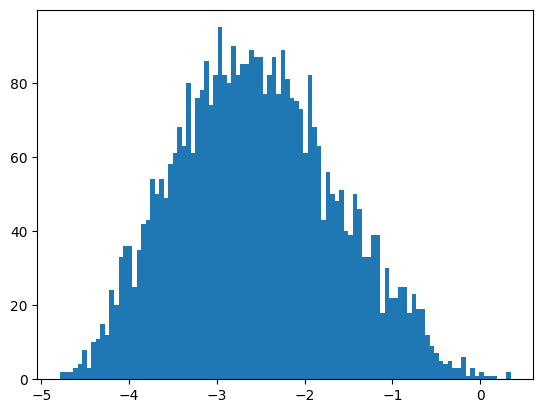

In [224]:
plt.hist(np.log(h_CAG_/h_HTT_),bins=100)

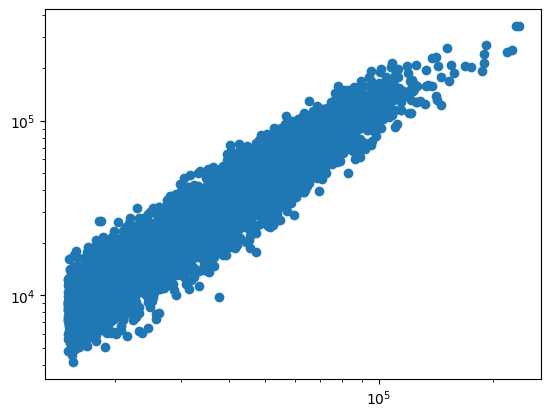

In [221]:
plt.loglog(Xh0f[:,-1],h_HTT_,'o')

(array([ 2.,  0.,  0.,  2.,  2.,  4.,  6.,  3.,  5., 15.,  5., 17.,  8.,
        12., 14., 30., 31., 25., 28., 26., 36., 30., 42., 54., 58., 53.,
        41., 52., 66., 56., 64., 57., 50., 78., 66., 62., 77., 91., 66.,
        83., 86., 65., 93., 67., 90., 78., 95., 66., 90., 69., 83., 78.,
        68., 64., 83., 77., 80., 71., 64., 70., 67., 63., 63., 42., 48.,
        55., 56., 45., 54., 51., 42., 50., 43., 33., 43., 38., 31., 46.,
        22., 24., 29., 32., 29., 16., 15., 16., 13., 10.,  9.,  5.,  2.,
        10.,  2.,  1.,  1.,  4.,  0.,  1.,  1.,  1.]),
 array([-4.04095125, -3.99696946, -3.95298767, -3.90900588, -3.86502409,
        -3.8210423 , -3.77706051, -3.73307872, -3.68909693, -3.64511514,
        -3.60113335, -3.55715132, -3.51316953, -3.46918774, -3.42520595,
        -3.38122416, -3.33724236, -3.29326057, -3.24927878, -3.20529699,
        -3.1613152 , -3.11733341, -3.07335162, -3.02936983, -2.98538804,
        -2.94140625, -2.89742446, -2.85344267, -2.80946088, -2.765479

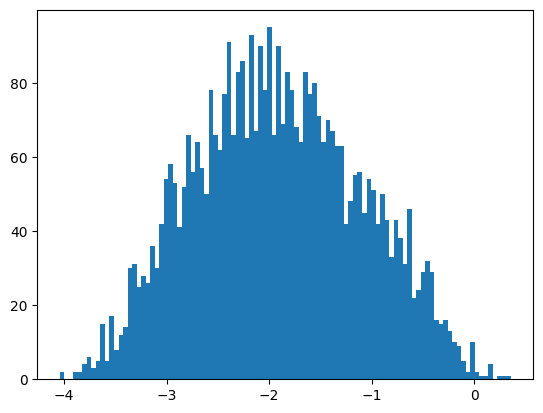

In [192]:
plt.hist(np.log(h_CAG_/h_HTT_),bins=100)

array([[3.2001066e+00, 3.7695172e+02, 1.5396489e+02, ..., 4.0830000e+03,
        8.2003462e-01, 2.6079887e+04],
       [3.7798200e+00, 3.2914337e+02, 1.9209830e+02, ..., 4.4820000e+03,
        8.6015195e-01, 3.2923758e+04],
       [4.6600924e+00, 3.4921350e+02, 1.8898468e+02, ..., 1.2595000e+04,
        7.7243078e-01, 1.2143288e+05],
       ...,
       [1.3111326e+01, 2.5709280e+03, 2.5820034e+03, ..., 2.9510000e+03,
        8.0552953e-01, 2.8353604e+04],
       [1.6178209e+01, 2.6157834e+03, 2.9770613e+03, ..., 2.5190000e+03,
        6.8203729e-01, 2.1842807e+04],
       [1.6844162e+01, 2.6149453e+03, 2.9760940e+03, ..., 2.8410000e+03,
        7.5194257e-01, 2.3906434e+04]], dtype=float32)

In [68]:
drft,flds,fov_,fl_ref = np.load(drift_fl,allow_pickle=True)

In [103]:
drft_CAG,fld_CAG = [(drft_[0],fld) for drft_,fld in zip(drft,flds) if 'Htt_CAG' in os.path.basename(fld)][0]
drft_Ab,fld_Ab = [(drft_[0],fld) for drft_,fld in zip(drft,flds) if 'LamA_' in os.path.basename(fld)][0]
im_Ab = np.array(read_im(fld_Ab+os.sep+fov_)[0],dtype=np.float32)
im_Ab_ = full_deconv(im_Ab,s_=500,pad=100,psf=np.load(r'C:\Scripts\NMERFISH\psfs\psf_750_Scope3_final.npy'),
            parameters={'method': 'wiener', 'beta': 0.001, 'niter': 50},gpu=True,force=False)
tzxyAb = np.round(drft_CAG-drft_Ab).astype(int)
im_Ab_T = np.roll(im_Ab_,-tzxyAb,axis=[0,1,2])


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:04<00:00,  7.82it/s]


In [106]:
drft_CAG,fld_CAG = [(drft_[0],fld) for drft_,fld in zip(drft,flds) if 'Htt_CAG' in os.path.basename(fld)][0]
drft_Ab,fld_Ab = [(drft_[0],fld) for drft_,fld in zip(drft,flds) if 'Htt_Nup98' in os.path.basename(fld)][0]
im_Ab = np.array(read_im(fld_Ab+os.sep+fov_)[1],dtype=np.float32)
im_Ab_ = full_deconv(im_Ab,s_=500,pad=100,psf=np.load(r'C:\Scripts\NMERFISH\psfs\psf_750_Scope3_final.npy'),
            parameters={'method': 'wiener', 'beta': 0.001, 'niter': 50},gpu=True,force=False)
tzxyAb = np.round(drft_CAG-drft_Ab).astype(int)
im_Ab_T = np.roll(im_Ab_,-tzxyAb,axis=[0,1,2])


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:04<00:00,  7.80it/s]


In [108]:
drft_CAG,fld_CAG = [(drft_[0],fld) for drft_,fld in zip(drft,flds) if 'Htt_CAG' in os.path.basename(fld)][0]
drft_Ab,fld_Ab = [(drft_[0],fld) for drft_,fld in zip(drft,flds) if 'SC35_gH2AX' in os.path.basename(fld)][0]
im_Ab = np.array(read_im(fld_Ab+os.sep+fov_)[1],dtype=np.float32)
im_Ab_ = full_deconv(im_Ab,s_=500,pad=100,psf=np.load(r'C:\Scripts\NMERFISH\psfs\psf_750_Scope3_final.npy'),
            parameters={'method': 'wiener', 'beta': 0.001, 'niter': 50},gpu=True,force=False)
tzxyAb = np.round(drft_CAG-drft_Ab).astype(int)
im_Ab_T = np.roll(im_Ab_,-tzxyAb,axis=[0,1,2])


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:04<00:00,  7.98it/s]


In [111]:
drft_CAG,fld_CAG = [(drft_[0],fld) for drft_,fld in zip(drft,flds) if 'Htt_CAG' in os.path.basename(fld)][0]
drft_Ab,fld_Ab = [(drft_[0],fld) for drft_,fld in zip(drft,flds) if 'gH2AX_PSMB5' in os.path.basename(fld)][0]
im_Ab = np.array(read_im(fld_Ab+os.sep+fov_)[0],dtype=np.float32)
im_Ab_ = full_deconv(im_Ab,s_=500,pad=100,psf=np.load(r'C:\Scripts\NMERFISH\psfs\psf_750_Scope3_final.npy'),
            parameters={'method': 'wiener', 'beta': 0.001, 'niter': 50},gpu=True,force=False)
tzxyAb = np.round(drft_CAG-drft_Ab).astype(int)
im_Ab_T = np.roll(im_Ab_,-tzxyAb,axis=[0,1,2])


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:04<00:00,  7.94it/s]


In [114]:
flds

['\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H1_MER2col__set5',
 '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H13_MER2col__set5',
 '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\H25_MER2col__set5',
 '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H37_MER2col__set5',
 '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\H49_MER2col__set5',
 '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\H61_MER2col__set5',
 '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H0__set5',
 '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\A1_Htt_Nup98__set5',
 '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\A2_LamA_B__set5',
 '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\A3_SC35_gH2AX__set5',
 '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\A4_gH2AX_PSMB5__set5',
 '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\P1__Gad1_Nrgn_Aqp4__set5',
 '\\\\192.168.0.96\\bbfish124\\H

In [112]:
#im_gama_cy5 = im_Ab_T
im_gama_750 = im_Ab_T

In [105]:
#im_sc35 = im_Ab_T.copy()
#im_lamA = im_Ab_T.copy()

In [113]:
v.add_image(im_Ab_T,name='Gamma_750')

<Image layer 'Gamma_750' at 0x24fe4020ca0>

In [99]:
im_HTTAb = im_Ab_T.copy()

In [93]:
flds

['\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H1_MER2col__set5',
 '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H13_MER2col__set5',
 '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\H25_MER2col__set5',
 '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H37_MER2col__set5',
 '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\H49_MER2col__set5',
 '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\H61_MER2col__set5',
 '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H0__set5',
 '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\A1_Htt_Nup98__set5',
 '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\A2_LamA_B__set5',
 '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\A3_SC35_gH2AX__set5',
 '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\A4_gH2AX_PSMB5__set5',
 '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\P1__Gad1_Nrgn_Aqp4__set5',
 '\\\\192.168.0.96\\bbfish124\\H

In [102]:
im_Ab_dapi = np.array(read_im(fld_Ab+os.sep+fov_)[-1],dtype=np.float32)
im_Ab_dapi_ = full_deconv(im_Ab_dapi,s_=500,pad=100,psf=np.load(r'C:\Scripts\NMERFISH\psfs\psf_750_Scope3_final.npy'),
            parameters={'method': 'wiener', 'beta': 0.001, 'niter': 50},gpu=True,force=False)
im_Ab_dapi_T = np.roll(im_Ab_dapi_,-tzxyAb,axis=[0,1,2])
v.add_image(im_Ab_dapi_T,name='dapi2')

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:04<00:00,  8.07it/s]


<Image layer 'dapi2' at 0x25106acddf0>

In [98]:
v.add_image(im_Ab_T,name='dapi')

<Image layer 'dapi [1]' at 0x25269bec250>

<Image layer 'dapi' at 0x25209c0a4f0>

In [72]:
flds

['\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H1_MER2col__set5',
 '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H13_MER2col__set5',
 '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\H25_MER2col__set5',
 '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H37_MER2col__set5',
 '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\H49_MER2col__set5',
 '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\H61_MER2col__set5',
 '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\H0__set5',
 '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\A1_Htt_Nup98__set5',
 '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\A2_LamA_B__set5',
 '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\A3_SC35_gH2AX__set5',
 '\\\\192.168.0.96\\bbfish124\\HttHuman_Snonia__06_12_2023\\A4_gH2AX_PSMB5__set5',
 '\\\\192.168.0.21\\bbfishdc21\\HttHuman_Snonia__06_12_2023\\P1__Gad1_Nrgn_Aqp4__set5',
 '\\\\192.168.0.96\\bbfish124\\H

In [51]:
np.percentile(Xh1[:,-1],99)

15142.486572265625

In [45]:
import napari
fl = r'\\192.168.0.96\bbfish124\HttHuman_Snonia__06_12_2023\P3__Htt_CAG_B_polyA_'+set_+os.sep+fov+'.zarr'
im = read_im(fl)
#im2d = np.max(np.array(im[0]),axis=0)
imCAG = np.array(im[1],dtype=np.float32)
#imCAG_ = full_deconv(imCAG,s_=500,pad=100,psf=np.load(r'C:\Scripts\NMERFISH\psfs\psf_750_Scope3_final.npy'),
#            parameters={'method': 'wiener', 'beta': 0.001, 'niter': 50},gpu=True,force=False)

imCAG__ = full_deconv(imCAG,s_=500,pad=100,psf=np.load(r'C:\Scripts\NMERFISH\psfs\psf_750_Scope3_final.npy'),
            parameters={'method': 'lucy', 'beta': 0.001, 'niter': 50},gpu=True,force=False)

imHTT = np.array(im[0],dtype=np.float32)
imHTT__ = full_deconv(imHTT,s_=500,pad=100,psf=np.load(r'C:\Scripts\NMERFISH\psfs\psf_750_Scope3_final.npy'),
            parameters={'method': 'lucy', 'beta': 0.001, 'niter': 50},gpu=True,force=False)

<Image layer 'imHTT__' at 0x2537cb3af10>

In [ ]:
imCAG_ = full_deconv(imCAG,s_=500,pad=100,psf=np.load(r'C:\Scripts\NMERFISH\psfs\psf_750_Scope3_final.npy'),
            parameters={'method': 'wiener', 'beta': 0.001, 'niter': 50},gpu=True,force=False)

In [61]:
imCAG__ = full_deconv(imCAG,s_=500,pad=100,psf=np.load(r'C:\Scripts\NMERFISH\psfs\psf_750_Scope3_final.npy'),
            parameters={'method': 'lucy', 'beta': 0.001, 'niter': 50},gpu=True,force=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [01:51<00:00,  3.10s/it]


In [58]:
imHTT = np.array(im[0],dtype=np.float32)
imCAG = np.array(im[1],dtype=np.float32)

In [ ]:
im  = da.roll(read_im(fld_+os.sep+fov_),drft[0],axis=[1,2,3])

In [64]:
#imHTT_ = full_deconv(imHTT,s_=500,pad=100,psf=np.load(r'C:\Scripts\NMERFISH\psfs\psf_750_Scope3_final.npy'),
#            parameters={'method': 'wiener', 'beta': 0.001, 'niter': 50},gpu=True,force=False)

In [63]:
import napari
tree = cKDTree(Xh1[:,:3])
d,inds = tree.query(Xh0f[:,:3])
v = napari.Viewer()
v.add_image(imCAG_)
v.add_image(imHTT_)
Xh1_ = Xh1[inds[d<2.5]]
X = Xh1_[:,:3]
s = Xh1_[:,-1]/15000*10
v.add_points(X,face_color=[0,0,0,0],edge_color='r',size=s)

<Points layer 'X' at 0x24ef98b9c40>

In [ ]:
v.add_image(imCAG_)

In [46]:
v = napari.Viewer()
v.add_image(im2d)
v.add_points(Xh0[Xh0[:,-1]>13000,1:3],face_color=[0,0,0,0],edge_color='r')

<Points layer 'Points' at 0x24e883dad60>

In [36]:
np.exp(9.2)

9897.129058743909

(array([4.010e+02, 4.460e+02, 4.550e+02, 4.900e+02, 5.570e+02, 5.370e+02,
        5.840e+02, 6.790e+02, 7.060e+02, 7.450e+02, 7.650e+02, 8.640e+02,
        9.070e+02, 9.940e+02, 1.035e+03, 1.065e+03, 1.135e+03, 1.150e+03,
        1.312e+03, 1.329e+03, 1.395e+03, 1.445e+03, 1.550e+03, 1.592e+03,
        1.602e+03, 1.703e+03, 1.792e+03, 1.850e+03, 1.819e+03, 1.991e+03,
        1.994e+03, 1.997e+03, 2.013e+03, 2.002e+03, 2.063e+03, 2.043e+03,
        2.000e+03, 1.965e+03, 2.051e+03, 1.868e+03, 1.824e+03, 1.792e+03,
        1.680e+03, 1.732e+03, 1.517e+03, 1.492e+03, 1.279e+03, 1.289e+03,
        1.117e+03, 9.760e+02, 8.520e+02, 7.220e+02, 6.450e+02, 5.330e+02,
        4.250e+02, 3.680e+02, 2.990e+02, 2.400e+02, 2.020e+02, 1.890e+02,
        1.960e+02, 1.760e+02, 1.390e+02, 1.410e+02, 1.670e+02, 1.650e+02,
        1.590e+02, 1.410e+02, 1.350e+02, 1.700e+02, 1.410e+02, 1.470e+02,
        1.700e+02, 1.550e+02, 1.690e+02, 1.730e+02, 1.610e+02, 1.790e+02,
        1.970e+02, 1.700e+02, 1.460e+0

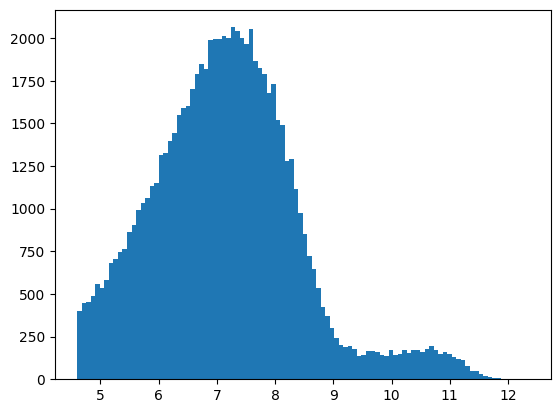

In [30]:
plt.hist(np.log(Xh0[:,-1]-3500),bins=100)